In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.models import load_model


# from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
import tensorflow.keras.layers as L
# import tensorflow.keras.layers as Layers

C:\Users\admin\AppData\Local\Temp\ipykernel_12564\4235188594.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


________________________________________________________________________________
# Data Preperation & Cleaning



## 1. Load .csv into a dataframe with the image paths

In [2]:
# Load the metadata into a DataFrame
metadata_path = 'C:\\Users\\admin\\Desktop\\archive\\Data_Entry_2017.csv'
all_xray_df = pd.read_csv(metadata_path)

# Adjust the glob pattern to match the new subfolder structure and file naming pattern
image_folder_path = 'C:\\Users\\admin\\Desktop\\archive'
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(image_folder_path, 'images_0**', 'images', '*.png'))}

# Check if all files follow the expected naming pattern
expected_files = all_xray_df['Image Index'].tolist()
missing_files = [file for file in expected_files if file not in all_image_paths]
print(f"Number of files not found: {len(missing_files)}")

# Map Full Image Paths to the DataFrame
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# Print the number of missing image paths after mapping
nan_or_none_count = all_xray_df['path'].isna().sum()
print(f"Total count of rows without valid image paths: {nan_or_none_count}")

# Display the head of the DataFrame to verify the 'path' column
all_xray_df


Number of files not found: 0
Total count of rows without valid image paths: 0


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...


In [3]:
# an extra column, 'unnamed:11' appeared. Check out what values are inside
print(all_xray_df['Unnamed: 11'].unique())


[nan]


In [4]:
# 'unamed:11' column only contains '[nan]', therefore it does not contain any useful data and can be dropped. 
# Likely to be an issue with the original .csv file
all_xray_df = all_xray_df.drop('Unnamed: 11', axis=1)


In [5]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,C:\Users\admin\Desktop\archive\images_001\imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,C:\Users\admin\Desktop\archive\images_001\imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,C:\Users\admin\Desktop\archive\images_001\imag...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,C:\Users\admin\Desktop\archive\images_001\imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,C:\Users\admin\Desktop\archive\images_001\imag...
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_012\imag...
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_012\imag...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_012\imag...
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_012\imag...


### 3.2: Patient Age - Remove >100

In [6]:
print(all_xray_df['Patient Age'].describe())


count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64


In [7]:
## find out number of people who have >100 in this column

age_over_100_count = all_xray_df[all_xray_df['Patient Age'] > 100].shape[0]
print(f"Number of people with age > 100: {age_over_100_count}")
over_100 = all_xray_df[all_xray_df['Patient Age'] > 100]

all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]
print(f"DataFrame shape after removal: {all_xray_df.shape}")
# oldest person in the world is 117, anything above that should be removed

Number of people with age > 100: 16
DataFrame shape after removal: (112104, 12)


## 4. Remove those with no findings

In [8]:
all_xray_df = all_xray_df[all_xray_df['Finding Labels'] != 'No Finding']
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,C:\Users\admin\Desktop\archive\images_001\imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,C:\Users\admin\Desktop\archive\images_001\imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,C:\Users\admin\Desktop\archive\images_001\imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143000,0.143000,C:\Users\admin\Desktop\archive\images_001\imag...
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168000,0.168000,C:\Users\admin\Desktop\archive\images_001\imag...
...,...,...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,Consolidation|Pleural_Thickening,7,30786,61,F,AP,3056,2544,0.139000,0.139000,C:\Users\admin\Desktop\archive\images_012\imag...
112100,00030789_000.png,Infiltration,0,30789,52,F,PA,2021,2021,0.194311,0.194311,C:\Users\admin\Desktop\archive\images_012\imag...
112106,00030793_000.png,Mass|Nodule,0,30793,58,F,PA,2021,2021,0.194311,0.194311,C:\Users\admin\Desktop\archive\images_012\imag...
112108,00030795_000.png,Pleural_Thickening,0,30795,53,F,PA,2021,2021,0.194311,0.194311,C:\Users\admin\Desktop\archive\images_012\imag...


#5 4. Split the 'labelled' columns into binary columns

In [9]:
# Assuming all_xray_df is your DataFrame and it's loaded and has the 'Finding Labels' column

# List of disease labels, including 'No Finding'
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 
                  'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 
                  'Pneumonia', 'Pneumothorax']

# Make sure that all_xray_df is not a view or a copy of another DataFrame
all_xray_df = all_xray_df.copy()

# Creating binary columns for each disease label using .loc
for label in disease_labels:
    all_xray_df.loc[:, label] = all_xray_df['Finding Labels'].apply(lambda findings: 
                                                                    1 if label in findings.split('|') else 0)

# Display the head of the DataFrame to check the new columns
all_xray_df


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,...,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,...,1,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143000,...,0,0,0,1,0,0,0,0,0,0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168000,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,Consolidation|Pleural_Thickening,7,30786,61,F,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,1,0,0
112100,00030789_000.png,Infiltration,0,30789,52,F,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,0
112106,00030793_000.png,Mass|Nodule,0,30793,58,F,PA,2021,2021,0.194311,...,0,0,0,0,0,1,1,0,0,0
112108,00030795_000.png,Pleural_Thickening,0,30795,53,F,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,1,0,0


## 4. Split into Train, Validate & Test

In [10]:
from sklearn.model_selection import train_test_split

# Assuming 'Patient ID' is the column with patient identifiers in all_xray_df

# First, get a list of unique patient IDs and split this list into train + validation and test IDs
unique_patients = all_xray_df['Patient ID'].unique()
train_valid_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=2024)

# Now split the train + validation IDs into train IDs and validation IDs
train_ids, valid_ids = train_test_split(train_valid_ids, test_size=0.25, random_state=2024)  # 0.25 * 0.8 = 0.2

# Create the actual dataframes based on the split IDs
train_df = all_xray_df[all_xray_df['Patient ID'].isin(train_ids)]
valid_df = all_xray_df[all_xray_df['Patient ID'].isin(valid_ids)]
test_df = all_xray_df[all_xray_df['Patient ID'].isin(test_ids)]

## 5. Prevent Data Leakage
our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [11]:
def check_for_leakage(df1, df2, patient_col):
    """
    Check for data leakage between two datasets by comparing unique patient identifiers.
    
    Args:
    df1 (DataFrame): the first dataset
    df2 (DataFrame): the second dataset
    patient_col (str): the name of the column containing patient identifiers
    
    Returns:
    bool: True if there is data leakage, False otherwise
    """
    df1_patients_unique = set(df1[patient_col].unique())
    df2_patients_unique = set(df2[patient_col].unique())
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    
    # If there's any overlap in patient identifiers, there's leakage
    leakage = len(patients_in_both_groups) > 0
    return leakage

# Example usage:
# Assuming 'Patient ID' is the column with patient identifiers in all_xray_df and the datasets have been created
# Check for leakage between train and test sets
leakage_between_train_test = check_for_leakage(train_df, test_df, 'Patient ID')
print(f"Leakage between train and test sets: {leakage_between_train_test}")

# Check for leakage between train and validation sets
leakage_between_train_valid = check_for_leakage(train_df, valid_df, 'Patient ID')
print(f"Leakage between train and validation sets: {leakage_between_train_valid}")

# Check for leakage between validation and test sets
leakage_between_valid_test = check_for_leakage(valid_df, test_df, 'Patient ID')
print(f"Leakage between validation and test sets: {leakage_between_valid_test}")


Leakage between train and test sets: False
Leakage between train and validation sets: False
Leakage between validation and test sets: False


## 6. Preparing Images with tf.data

- to resize images to the same size
- memory efficiency: loads iamges in batches
- preprocess images the same way the images were preprocessed when training the models (e.g., normalizing pixel values). Consistent preprocessing is essential for the model to perform correctly.

In [12]:
import tensorflow as tf

def load_image_and_process(filepath, label, augment=False):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Assuming you already have train_df, valid_df, and test_df ready, with label columns properly set up
# Convert the label data to categorical format if it's not already done
train_labels = train_df[disease_labels].values
valid_labels = valid_df[disease_labels].values
test_labels = test_df[disease_labels].values

# Create a tf.data.Dataset from the DataFrame
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['path'].values, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['path'].values, test_labels))

# Process the image and batch the datasets
batch_size = 32
# Apply augmentation only to training data
train_ds = train_ds.map(lambda x, y: load_image_and_process(x, y, augment=True)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(load_image_and_process).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(load_image_and_process).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# augmentation only for train to prevent overfitting, Maintaining Validity of Validation and Test Data, simulate real test conditions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


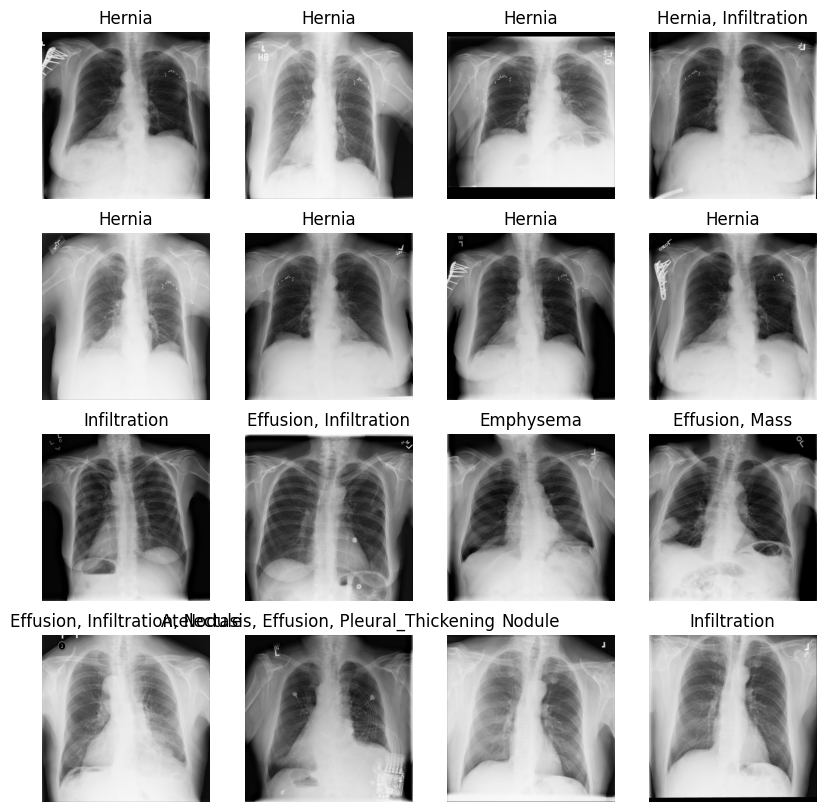

In [13]:
# Visualize the images
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.axis("off")
    plt.show()

# Fetch a batch of images and labels from the dataset
image_batch, label_batch = next(iter(train_ds))

# Since labels are in binary format, you might want to map them back to the disease names for display
def format_labels(label_batch, disease_labels):
    formatted_labels = []
    for labels in label_batch:
        label_names = [disease_labels[idx] for idx, label in enumerate(labels) if label == 1]
        if not label_names:  # If no disease is present
            label_names = ['No Finding']
        formatted_labels.append(', '.join(label_names))
    return formatted_labels

# Convert binary labels back to string labels for easier interpretation
formatted_labels = format_labels(label_batch.numpy(), disease_labels)

# Call the function to display the images and their corresponding labels
show_batch(image_batch.numpy(), formatted_labels)


________________________________________________________________________________________________________________________
# Exploratory Data Analysis - Skipped

________________________________________________________________________________________________________________________
# Machine Learning Techniques

## 1. Construct a CNN using keras

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define the CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  # Explicit Input layer specifying the input shape
        # First convolutional layer with 32 filters, a kernel size of 3x3, and ReLU activation
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Second convolutional layer with 64 filters and a kernel size of 3x3, followed by a MaxPooling layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Third convolutional layer with 64 filters and a kernel size of 3x3
        Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten the output of the convolutions to feed into the dense layer
        Flatten(),
        
        # Dense layer with 64 neurons
        Dense(64, activation='relu'),
        Dropout(0.5),  # Dropout for regularization
        
        # Output layer with 'num_classes' neurons, one for each class, using softmax activation for classification
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model with a suitable optimizer, loss function, and metric for classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Assuming the input images are 512x512 pixels with 3 color channels (RGB)
input_shape = (512, 512, 3)
# Assuming we have 14 classes
num_classes = 14

# Build the model
model = build_model(input_shape, num_classes)

# Print the model summary to see the structure and parameters
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 984064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      62,980,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,037,390 (240.47 MB)

 Trainable params: 63,037,390 (240.47 MB)

 Non-trainable params: 0 (0.00 B)

## 2. Train the model

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use binary crossentropy for multi-label classification
    metrics=['accuracy']
)

# Assuming 'train_dataset' and 'valid_dataset' are the tf.data.Dataset objects for training and validation
#Define the number of epochs to train for
epochs = 5

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds
)

# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


Epoch 1/5
566/974 ━━━━━━━━━━━━━━━━━━━━ 19:41 3s/step - accuracy: 0.1412 - loss: 0.4631

In [ ]:
import numpy as np

# This function assumes that 'test_Y' is a NumPy array or a TensorFlow tensor
# where each row corresponds to a sample and each column to a class.
# The values in 'test_Y' should be binary (0 or 1), indicating the absence or presence
# of the class in the sample, respectively.

def print_class_distribution(labels, predictions):
    # Calculate the percentage of positive examples for each class
    class_percentages = 100 * np.mean(predictions, axis=0)
    
    # Print out the percentage of positive examples for each class
    for label, percentage in zip(labels, class_percentages):
        print('{label}: {percentage:.2f}%'.format(label=label, percentage=percentage))

# Assuming you have a list of class labels corresponding to your model's output
all_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
              'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule',
              'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# And assuming you have a test set of true labels (not predictions) in a NumPy array
# Let's simulate this with random binary data for demonstration purposes:
test_Y = np.random.randint(2, size=(100, len(all_labels)))  # Simulated binary labels for 100 samples

# Now you can call the function with your labels and predictions
print_class_distribution(all_labels, test_Y)
